# 02: Naive Bayes Model Optimization and Comparative Analysis

This notebook constructs and assesses a Naive Bayes sentiment classifier. It first optimizes a baseline model on the `jerbarnes_dataset` by selecting optimal text preprocessing, feature representation, imbalance handling, and classifier hyperparameters. Next, the `crowdsourced_dataset` is added to the `jerbarnes_dataset` training data; the baseline model configuration is retrained on this combined set and evaluated against the original `jerbarnes_dataset` test set. Finally, the model is re-optimized from scratch using the full combined training data. Performance throughout is measured using Stratified K-Fold cross-validation and F1-macro scores.

This cell imports all required Python libraries for data handling (pandas), machine learning (scikit-learn, imblearn), model persistence (joblib), and visualization (matplotlib, numpy). It also defines the `DATA_DIR` path, pointing to the location of the preprocessed dataset files from Notebook 01.

In [2]:
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import preprocessor # preprocessor.py

DATA_DIR = Path('./data')

The `train_model` function is defined to evaluate scikit-learn pipeline performance. It uses Stratified 5-Fold cross-validation to train and test a given pipeline on input data (`X`, `y`). The function returns a dictionary containing the mean and standard deviation for accuracy, macro-averaged precision, recall, and F1-score.

In [3]:
def train_model(pipeline, X, y, n_folds=5):
    # Create Stratified K-fold cross validator
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Perform cross validation
    scores = cross_validate(pipeline, X, y, 
                          cv=skf,
                          scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                          return_train_score=True)
    
    # Create dictionary of results
    cv_results = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2)
    }
        
    return cv_results

Two scikit-learn pipelines are defined to test between the MultinomialNB classifier and the ComplementNB classifier. Both classifiers use plain Bag of Words with `min_df=2`; `lowercase=False`, since text case was handled during prior data preprocessing.

In [4]:
# Create a pipeline with vectorizer and MultinomialNB classifier
bow_mnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None)),
    ('classifier', MultinomialNB())
])

# Create a pipeline with vectorizer and ComplementNB classifier
bow_cnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None)),
    ('classifier', ComplementNB())
])

pipelines = [bow_mnb_pipeline, bow_cnb_pipeline]
pipeline_names = ['Multinomial (Bag of Words)', 'Complement (Bag of Words)']

The `tokenizer_configs` list defines the four text preprocessing strategies (combinations of full/selective lowercasing and with/without lemmatization) that were applied to the `jerbarnes_dataset` in Notebook 01. A configuration representing no preprocessing (no case folding and no lemmatization) is also defined.

In [5]:
# Define tokenizer configurations
tokenizer_configs = [
    {
        'case_folding_type': 0,  # no case folding
        'lemmatize': False,
        'output_suffix': 'no_preprocessing'
    },
    {
        'case_folding_type': 2,  # full lowercasing
        'lemmatize': True,
        'output_suffix': 'lowercased_lemmatized'
    },
    {
        'case_folding_type': 2,  # full lowercasing
        'lemmatize': False,
        'output_suffix': 'lowercased_no_lemmatization'
    },
    {
        'case_folding_type': 1,  # selective lowercasing
        'lemmatize': True,
        'output_suffix': 'selective_lowercased_lemmatized'
    },
    {
        'case_folding_type': 1,  # selective lowercasing
        'lemmatize': False,
        'output_suffix': 'selective_lowercased_no_lemmatization'
    },
    {
        'case_folding_type': 1,  # selective lowercasing
        'lemmatize': False,
        'output_suffix': 'selective_lowercased_no_lemmatization'
    }
]

To identify the most effective combination of text preprocessing and classifier for the `jerbarnes_dataset`, an experiment is conducted. The code iterates through each of the five versions of the `jerbarnes_dataset` (four preprocessed, one raw). For each version, both classifiers are trained and evaluated via the `train_model` cross-validation function, using only the 80% training split. The F1-macro scores (mean and standard deviation) are collected for all 16 resulting combinations.

In [6]:
f1_scores = {}

for config in tokenizer_configs:
    if config['output_suffix'] == 'no_preprocessing':
        # Load raw dataset
        dataset_path = DATA_DIR / 'jerbarnes_dataset.csv'

        df = pd.read_csv(dataset_path, header=None, names=['label', 'text'])
        X = df['text']
        y = df['label']

    else:
        dataset_path = DATA_DIR / f'jerbarnes_dataset_{config["output_suffix"]}.csv'
        df = pd.read_csv(dataset_path, header=None, names=['label', 'text', 'processed_text'])
        X = df['processed_text']
        y = df['label']

    config_name = config["output_suffix"]
    print(f"\n{dataset_path}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use only the training set for hyperoptimization
    for name, pipeline in zip(pipeline_names, pipelines):
        print(f"Pipeline: {name}")
        results = train_model(pipeline, X_train, y_train)

        # Ensure nested dictionary structure exists
        if config_name not in f1_scores:
            f1_scores[config_name] = {}

        # Store F1-score mean and std
        f1_scores[config_name][name] = results['f1']


data\jerbarnes_dataset.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)

data\jerbarnes_dataset_lowercased_lemmatized.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)

data\jerbarnes_dataset_lowercased_no_lemmatization.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)

data\jerbarnes_dataset_selective_lowercased_lemmatized.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)

data\jerbarnes_dataset_selective_lowercased_no_lemmatization.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)

data\jerbarnes_dataset_selective_lowercased_no_lemmatization.csv
Pipeline: Multinomial (Bag of Words)
Pipeline: Complement (Bag of Words)


The `plot_f1_scores` function creates a grouped bar chart to visually compare the F1-macro scores from the previous experiment. This chart displays the mean F1-scores, with error bars representing ±2 standard deviations, for each classifier across the five preprocessing methods used on the `jerbarnes_dataset`.

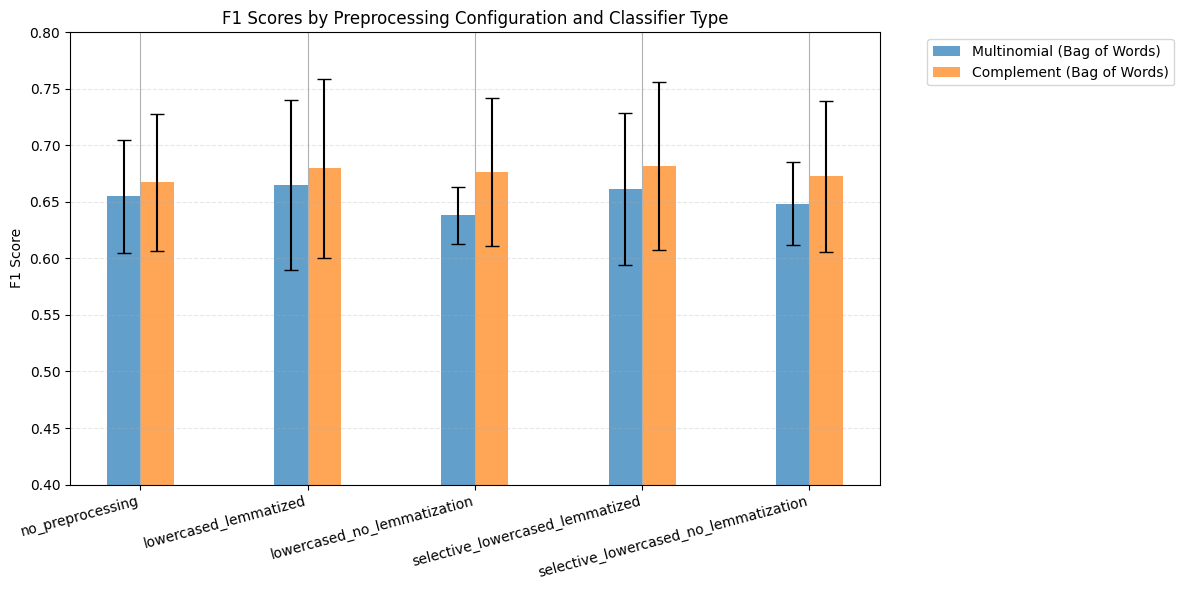

In [7]:
def plot_f1_scores(f1_scores):
    # Set basic style parameters
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    
    # Get dimensions
    configs = list(f1_scores.keys())
    pipelines = list(f1_scores[configs[0]].keys())
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate bar positions
    x = np.arange(len(configs))
    width = 0.2  # Width of bars
    
    # Define colors for better visibility
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    # Plot bars for each pipeline
    for i, (pipeline, color) in enumerate(zip(pipelines, colors)):
        means = [f1_scores[config][pipeline][0] for config in configs]
        stds = [f1_scores[config][pipeline][1] for config in configs]
        
        ax.bar(x + i*width - (len(pipelines)-1)*width/2, 
               means,
               width,
               label=pipeline,
               yerr=stds,
               capsize=5,
               color=color,
               alpha=0.7)
    
    # Customize the plot
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Preprocessing Configuration and Classifier Type')
    ax.set_xticks(x)
    ax.set_xticklabels(configs, rotation=15, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Set y-axis limits to focus on the relevant range
    ax.set_ylim(0.4, 0.8)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Create the plot
fig = plot_f1_scores(f1_scores)

# Show the plot
plt.show()

The `analyze_f1_scores` function processes the collected F1-scores to quantitatively identify the top-performing configurations on the `jerbarnes_dataset`. It prints the top 3 combinations based on three criteria: highest mean F1-score, lowest standard deviation (stability), and the best score from (mean F1 - standard deviation).

In [8]:
def analyze_f1_scores(f1_scores):
    # Create a flat list of all combinations with their scores
    results = []
    for config in f1_scores:
        for pipeline in f1_scores[config]:
            mean, std = f1_scores[config][pipeline]
            results.append({
                'config': config,
                'pipeline': pipeline,
                'mean_f1': mean,
                'std_f1': std,
                'mean_minus_std': mean - std  # A measure of stable performance
            })
    
    # Convert to sorted lists
    # Best mean F1 scores
    best_mean = sorted(results, key=lambda x: x['mean_f1'], reverse=True)[:3]
    print("\nTop 3 by mean F1 score:")
    for result in best_mean:
        print(f"Config: {result['config']}, Pipeline: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")
    
    # Most stable (lowest standard deviation)
    most_stable = sorted(results, key=lambda x: x['std_f1'])[:3]
    print("\nTop 3 by stability (lowest std):")
    for result in most_stable:
        print(f"Preprocessing: {result['config']}, Classifier: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")
    
    # Best combination of high mean and low std
    best_stable = sorted(results, key=lambda x: x['mean_minus_std'], reverse=True)[:3]
    print("\nTop 3 by combined performance (mean - std):")
    for result in best_stable:
        print(f"Preprocessing: {result['config']}, Classifier: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")

# Run the analysis
analyze_f1_scores(f1_scores)


Top 3 by mean F1 score:
Config: selective_lowercased_lemmatized, Pipeline: Complement (Bag of Words)
F1: 0.682 (±0.074)
Config: lowercased_lemmatized, Pipeline: Complement (Bag of Words)
F1: 0.680 (±0.079)
Config: lowercased_no_lemmatization, Pipeline: Complement (Bag of Words)
F1: 0.676 (±0.066)

Top 3 by stability (lowest std):
Preprocessing: lowercased_no_lemmatization, Classifier: Multinomial (Bag of Words)
F1: 0.638 (±0.025)
Preprocessing: selective_lowercased_no_lemmatization, Classifier: Multinomial (Bag of Words)
F1: 0.648 (±0.037)
Preprocessing: no_preprocessing, Classifier: Multinomial (Bag of Words)
F1: 0.655 (±0.050)

Top 3 by combined performance (mean - std):
Preprocessing: lowercased_no_lemmatization, Classifier: Multinomial (Bag of Words)
F1: 0.638 (±0.025)
Preprocessing: selective_lowercased_no_lemmatization, Classifier: Multinomial (Bag of Words)
F1: 0.648 (±0.037)
Preprocessing: lowercased_no_lemmatization, Classifier: Complement (Bag of Words)
F1: 0.676 (±0.066)


The F1-score analysis on the jerbarnes_dataset (80% training split) shows that the `lowercased_no_lemmatization` preprocessing with the `MultinomialNB` classifier offers the best combination of mean F1-score and stability (i.e., lowest standard deviation). However, the `selective_lowercased_lemmatized` preprocessing with the `ComplementNB` classifier achieves the highest mean F1-score (0.682 ± 0.074), albeit with a significantly higher standard deviation.

When analyzing the graph, the lower bound of this model’s error bars is only marginally below that of the MultinomialNB setup. Given its superior average F1-score and comparable worst-case performance, the `selective_lowercased_lemmatized` + `ComplementNB` configuration is selected for offering greater potential without a meaningful drop in stability.

Four scikit-learn pipelines are defined to test different text feature representation methods with a `ComplementNB` classifier and `selective_lowercased_lemmatized` dataset. These methods are TF-IDF, Bag-of-Words (CountVectorizer), Bag-of-Words with unigrams and bigrams and Bag-of-Words with only bigrams. All vectorizers use `min_df=2`; `lowercase=False` is set because text case was handled during prior data preprocessing.

In [9]:
# Create a pipeline with TF-IDF vectorizer and classifier
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None)),
    ('classifier', ComplementNB())
])

# Create a pipeline with vectorizer and classifier
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None)),
    ('classifier', ComplementNB())
])

# Create a pipeline with N-grams vectorizer  (unigrams and bigrams) and classifier
ngram_pipeline_1_2 = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('classifier', ComplementNB())
])

# Create a pipeline with N-grams vectorizer (bigrams only) and classifier
ngram_pipeline_2_2 = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(2, 2))),  # Use both unigrams and bigrams
    ('classifier', ComplementNB())
])

pipelines = [tfidf_pipeline, bow_pipeline, ngram_pipeline_1_2, ngram_pipeline_2_2]
pipeline_names = ['TF-IDF', 'Bag of Words', 'Ngrams (1-2)', 'Ngrams (2-2)']

In [10]:
# Load the dataset
dataset_path = DATA_DIR/f'jerbarnes_dataset_selective_lowercased_lemmatized.csv'
df = pd.read_csv(dataset_path, header=None, names=['label', 'text', 'processed_text'])

# Split data into features and target
X = df['processed_text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

f1_scores = {}

# Single loop through pipelines only
for name, pipeline in zip(pipeline_names, pipelines):
    print(f"Pipeline: {name}")
    results = train_model(pipeline, X_train, y_train)
    
    # Store F1-score mean and std
    f1_scores[name] = results['f1']

Pipeline: TF-IDF
Pipeline: Bag of Words
Pipeline: Ngrams (1-2)
Pipeline: Ngrams (2-2)


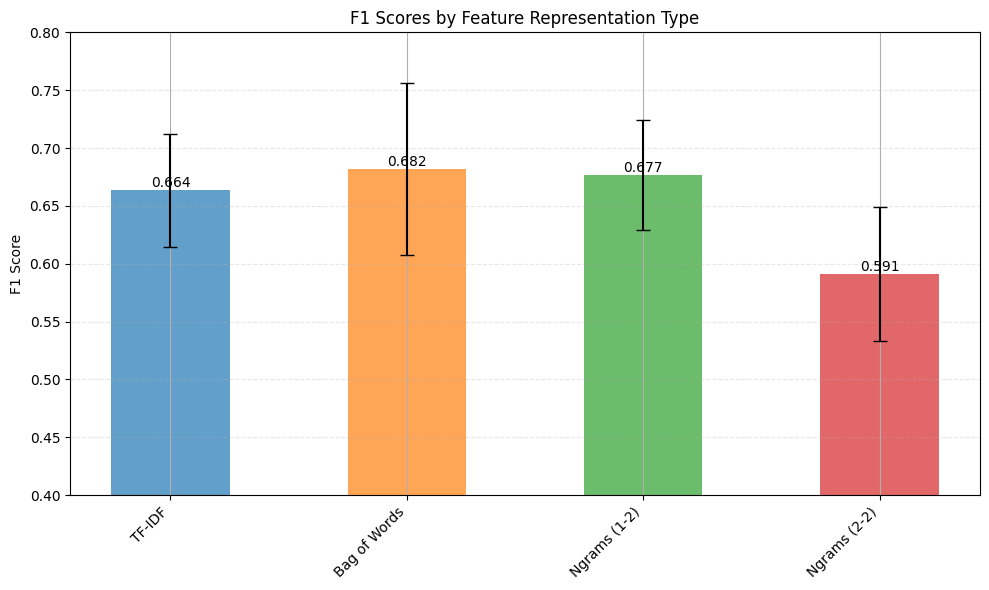

In [11]:
def plot_f1_scores(f1_scores):
    # Set basic style parameters
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True

    # Get dimensions
    pipelines = list(f1_scores.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate bar positions
    x = np.arange(len(pipelines))
    width = 0.5  # Can be wider now since we don't need to group bars

    # Define colors for better visibility
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot bars for each pipeline
    means = [f1_scores[pipeline][0] for pipeline in pipelines]
    stds = [f1_scores[pipeline][1] for pipeline in pipelines]
    
    bars = ax.bar(x, means, width, 
                  yerr=stds, 
                  capsize=5, 
                  color=colors[:len(pipelines)], 
                  alpha=0.7)

    # Customize the plot
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Feature Representation Type')
    ax.set_xticks(x)
    ax.set_xticklabels(pipelines, rotation=45, ha='right')

    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to focus on the relevant range
    ax.set_ylim(0.4, 0.8)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Create the plot
fig = plot_f1_scores(f1_scores)

# Show the plot
plt.show()

In [12]:
def analyze_f1_scores(f1_scores):
    # Create a flat list of all pipelines with their scores
    results = []
    for pipeline in f1_scores:
        mean, std = f1_scores[pipeline]
        results.append({
            'pipeline': pipeline,
            'mean_f1': mean,
            'std_f1': std,
            'mean_minus_std': mean - std  # A measure of stable performance
        })

    # Best mean F1 scores
    best_mean = sorted(results, key=lambda x: x['mean_f1'], reverse=True)[:3]
    print("\nPipelines ranked by mean F1 score:")
    for result in best_mean:
        print(f"Pipeline: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")

    # Most stable (lowest standard deviation)
    most_stable = sorted(results, key=lambda x: x['std_f1'])[:3]
    print("\nPipelines ranked by stability (lowest std):")
    for result in most_stable:
        print(f"Pipeline: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")

    # Best combination of high mean and low std
    best_stable = sorted(results, key=lambda x: x['mean_minus_std'], reverse=True)[:3]
    print("\nPipelines ranked by combined performance (mean - std):")
    for result in best_stable:
        print(f"Pipeline: {result['pipeline']}")
        print(f"F1: {result['mean_f1']:.3f} (±{result['std_f1']:.3f})")

# Run the analysis
analyze_f1_scores(f1_scores)


Pipelines ranked by mean F1 score:
Pipeline: Bag of Words
F1: 0.682 (±0.074)
Pipeline: Ngrams (1-2)
F1: 0.677 (±0.048)
Pipeline: TF-IDF
F1: 0.664 (±0.049)

Pipelines ranked by stability (lowest std):
Pipeline: Ngrams (1-2)
F1: 0.677 (±0.048)
Pipeline: TF-IDF
F1: 0.664 (±0.049)
Pipeline: Ngrams (2-2)
F1: 0.591 (±0.058)

Pipelines ranked by combined performance (mean - std):
Pipeline: Ngrams (1-2)
F1: 0.677 (±0.048)
Pipeline: TF-IDF
F1: 0.664 (±0.049)
Pipeline: Bag of Words
F1: 0.682 (±0.074)


The analysis of F1-scores on the `jerbarnes_dataset_selective_lowercased_lemmatized` dataset indicates that N-grams (1-2) feature representation offers the most effective balance of high mean F1-score and stability. Its mean F1 score is negligibly lower than the absolute highest (Bag of Words) while having a significantly better performance floor (Mean - Std). This configuration is therefore selected for the subsequent experiments.

Having selected 'selective_lowercased_lemmatized' preprocessing using a ComplementalNB with 'Ngrams (1-2)' feature representation, the next stage explores strategies to address the class imbalance in the `jerbarnes_dataset`. Five pipeline configurations are defined: a baseline Naive Bayes without specific imbalance handling, Naive Bayes with adjusted class priors for a 50/50 balance, and three Naive Bayes pipelines combined with `RandomUnderSampler` using different `sampling_strategy` values (0.5 for a 2:1 majority-to-minority ratio, 0.7 for a closer balance, and 1.0 for a fully balanced 1:1 ratio).

In [13]:
# Current Pipeline
naive_bayes = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('classifier', ComplementNB())
])

# Class Prior Adjustment
naive_bayes_balanced = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('classifier', ComplementNB(fit_prior=True, class_prior=[0.5, 0.5]))  # Equal class weights
])

# Imbalanced-Learn Pipelines with Undersampling
undersampling_50 = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),  # 2:1 ratio
    ('classifier', ComplementNB())
])

undersampling_70 = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('undersampler', RandomUnderSampler(sampling_strategy=0.7, random_state=42)),  # Closer balance
    ('classifier', ComplementNB())
])

undersampling_100 = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, 
                                 stop_words=None, ngram_range=(1, 2))),  # Use both unigrams and bigrams
    ('undersampler', RandomUnderSampler(sampling_strategy=1, random_state=42)),  # Fully balanced
    ('classifier', ComplementNB())
])

# List of Pipelines and Names
pipelines = [naive_bayes, naive_bayes_balanced, undersampling_50, undersampling_70, undersampling_100]
pipeline_names = ['Baseline Naïve Bayes', 'Class Prior Adjustment', 'Undersampling 50%', 'Undersampling 70%', 'Undersampling 100%']

The `jerbarnes_dataset_selective_lowercased_lemmatized` is loaded into a pandas DataFrame. Each of the five defined imbalance handling pipelines is then trained and evaluated on the training set data using the `train_model` cross-validation function. F1-macro scores (mean and standard deviation) are collected for each pipeline.

In [14]:
# Load the dataset
dataset_path = DATA_DIR/f'jerbarnes_dataset_selective_lowercased_lemmatized.csv'
df = pd.read_csv(dataset_path, header=None, names=['label', 'text', 'processed_text'])

# Split data into features and target
X = df['processed_text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

f1_scores = {}

# Single loop through pipelines only
for name, pipeline in zip(pipeline_names, pipelines):
    print(f"Pipeline: {name}")
    results = train_model(pipeline, X_train, y_train)
    
    # Store F1-score mean and std
    f1_scores[name] = results['f1']

Pipeline: Baseline Naïve Bayes
Pipeline: Class Prior Adjustment
Pipeline: Undersampling 50%
Pipeline: Undersampling 70%
Pipeline: Undersampling 100%


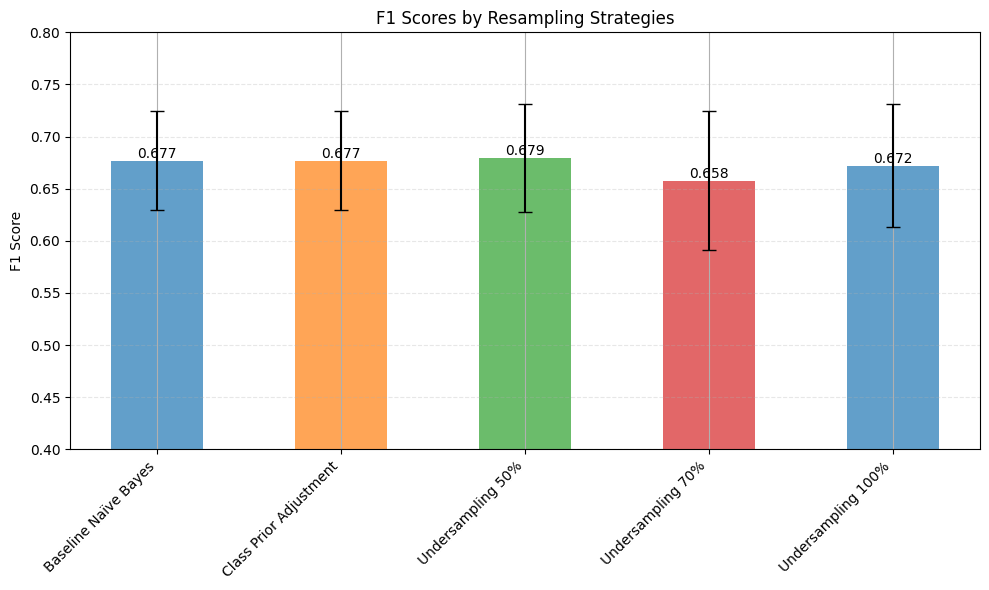

In [15]:
def plot_f1_scores(f1_scores):
    # Set basic style parameters
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True

    # Get dimensions
    pipelines = list(f1_scores.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate bar positions
    x = np.arange(len(pipelines))
    width = 0.5  # Can be wider now since we don't need to group bars

    # Define colors for better visibility
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot bars for each pipeline
    means = [f1_scores[pipeline][0] for pipeline in pipelines]
    stds = [f1_scores[pipeline][1] for pipeline in pipelines]
    
    bars = ax.bar(x, means, width, 
                  yerr=stds, 
                  capsize=5, 
                  color=colors[:len(pipelines)], 
                  alpha=0.7)

    # Customize the plot
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Resampling Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels(pipelines, rotation=45, ha='right')

    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to focus on the relevant range
    ax.set_ylim(0.4, 0.8)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Create the plot
fig = plot_f1_scores(f1_scores)

# Show the plot
plt.show()

The `analyze_f1_scores` function processes the collected F1-scores from the imbalance handling experiment. It identifies and prints the top 3 performing pipelines based on highest mean F1-score, lowest standard deviation (stability), and the best score from (mean F1 - standard deviation).

In [16]:
# Run the analysis
analyze_f1_scores(f1_scores)


Pipelines ranked by mean F1 score:
Pipeline: Undersampling 50%
F1: 0.679 (±0.052)
Pipeline: Baseline Naïve Bayes
F1: 0.677 (±0.048)
Pipeline: Class Prior Adjustment
F1: 0.677 (±0.048)

Pipelines ranked by stability (lowest std):
Pipeline: Baseline Naïve Bayes
F1: 0.677 (±0.048)
Pipeline: Class Prior Adjustment
F1: 0.677 (±0.048)
Pipeline: Undersampling 50%
F1: 0.679 (±0.052)

Pipelines ranked by combined performance (mean - std):
Pipeline: Baseline Naïve Bayes
F1: 0.677 (±0.048)
Pipeline: Class Prior Adjustment
F1: 0.677 (±0.048)
Pipeline: Undersampling 50%
F1: 0.679 (±0.052)


The F1-score analysis for imbalance handling strategies on the dataset indicates that Baseline (Complemental) Naïve Bayes provides the best balance of mean F1 score and stability. This strategy is therefore selected for the final hyperparameter tuning stage of the baseline Jerbarnes model.

The final optimization step for the Jerbarnes model is tuning the `alpha` (smoothing parameter) of the classifier. A `param_grid` is defined with a range of `alpha` values: `[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0]`. `GridSearchCV` is then configured to find the best `alpha` for the `naive_bayes` pipeline. As in previous steps, the search uses 5-fold stratified cross-validation and optimizes for the `f1_macro` score.

The grid search is then executed and the best `alpha` parameter and corresponding best F1-macro score are printed.

In [17]:
# Define parameter grid
param_grid = {
    'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0]
}

# Create grid search with your best pipeline
grid_search = GridSearchCV(
    naive_bayes,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-macro: {grid_search.best_score_}")


Best parameters: {'classifier__alpha': 0.75}
Best F1-macro: 0.6887236786447952


The `jerbarnes_dataset_selective_lowercased_lemmatized` data is loaded again. The optimal pipeline configuration for the Jerbarnes dataset (N-Grams (1-2), No undersampling, and `ComplementalNB` with an `alpha` of 0.75) is instantiated as `optimized_model`. To evaluate its performance on unseen data, the dataset is split into an 80% training set and a 20% test set. The `optimized_model` is then trained on this specific training split and evaluated on the corresponding test split. The full classification report for this "Optimized Jerbarnes Model" (henceforth Model A) is printed, and its metrics are stored as a dictionary in `model_a_results` for later comparisons.

In [18]:
# Load the dataset
dataset_path = DATA_DIR/f'jerbarnes_dataset_selective_lowercased_lemmatized.csv'
df = pd.read_csv(dataset_path, header=None, names=['label', 'text', 'processed_text'])

# Split data into features and target
X = df['processed_text']
y = df['label']

optimized_model = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('classifier', ComplementNB(alpha=0.75))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
optimized_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = optimized_model.predict(X_test)

model_a_results = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.82      0.81       119
           1       0.55      0.50      0.53        52

    accuracy                           0.73       171
   macro avg       0.67      0.66      0.67       171
weighted avg       0.72      0.73      0.72       171



The preprocessed `crowdsourced_dataset_selective_lowercased_lemmatized.csv` is loaded. Its features (`new_X`) and labels (`new_y`) are then appended to the `jerbarnes_dataset` training split (`X_train`, `y_train`) to create the combined training sets `X_train_combined` and `y_train_combined`.

Model B is then trained on `X_train_combined` and `y_train_combined`. Its performance is then evaluated against the original `jerbarnes_dataset` test split (`X_test`, `y_test`), with the classification report printed and the results stored as `model_b_results`.

In [19]:
# Load the crowd-sourced dataset
new_dataset_path = DATA_DIR/f'crowdsourced_dataset_selective_lowercased_lemmatized.csv'
new_df = pd.read_csv(new_dataset_path, header=None, names=['label', 'text', 'processed_text'])

# Split data into features and target
new_X = new_df['processed_text']
new_y = new_df['label']

# Add crowd-sourced data to training set
X_train_combined = pd.concat([X_train, new_X], ignore_index=True)
y_train_combined = pd.concat([y_train, new_y], ignore_index=True)

# Train the model using the combined data
optimized_model.fit(X_train_combined, y_train_combined)

# Make predictions and evaluate
y_pred = optimized_model.predict(X_test)

model_b_results = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85       119
           1       0.70      0.50      0.58        52

    accuracy                           0.78       171
   macro avg       0.75      0.70      0.72       171
weighted avg       0.77      0.78      0.77       171



The combined training set (`X_train_combined`, `y_train_combined`) is now used to re-optimize a new model (Model C) from scratch. Since the addition of the crowdsourced data results in `X_train_combined` being significantly more balanced (approx. 52% Class 0, 48% Class 1), this stage re-evaluates if an imbalance strategy is still necessary, and if so, which is optimal for this new data distribution. The subsequent code defines four Ngrams (1-2) based pipelines: `MultinomialNB` with no explicit imbalance handling, `MultinomialNB` with adjusted 50/50 class priors, `MultinomialNB` with `RandomUnderSampler` enforcing a 1:1 class ratio and `ComplementNB`. These will be evaluated on `X_train_combined` via cross-validation to select the best approach before `alpha` tuning for Model C.


In [20]:
# No Imbalance Handling
mb_naive_bayes = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

# Class Prior Adjustment
naive_bayes_balanced = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('classifier', MultinomialNB(fit_prior=True, class_prior=[0.5, 0.5]))  # Equal class weights
])

undersampling_100 = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('undersampler', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),  # Fully balanced
    ('classifier', MultinomialNB())
])

complement_nb = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('classifier', ComplementNB())
])

# List of Pipelines and Names
pipelines = [mb_naive_bayes, naive_bayes_balanced, undersampling_100, complement_nb]
pipeline_names = ['Multinomial Naïve Bayes', 'Class Prior Adjustment', 'Undersampling 100%', 'Complement Naïve Bayes']

Each of the imbalance handling pipelines is now trained and evaluated using 5-fold stratified cross-validation on the `X_train_combined` and `y_train_combined` data. The F1-macro scores (mean and standard deviation) for each pipeline are collected to determine the most effective approach for Model C.

In [21]:
f1_scores = {}

# Single loop through pipelines only
for name, pipeline in zip(pipeline_names, pipelines):
    print(f"Pipeline: {name}")
    results = train_model(pipeline, X_train_combined, y_train_combined)
    
    # Store F1-score mean and std
    f1_scores[name] = results['f1']

Pipeline: Multinomial Naïve Bayes
Pipeline: Class Prior Adjustment
Pipeline: Undersampling 100%
Pipeline: Complement Naïve Bayes


The `plot_f1_scores` function is used to to visually display the mean F1-macro scores and error bars from the evaluation of the three imbalance handling strategies on `X_train_combined`.

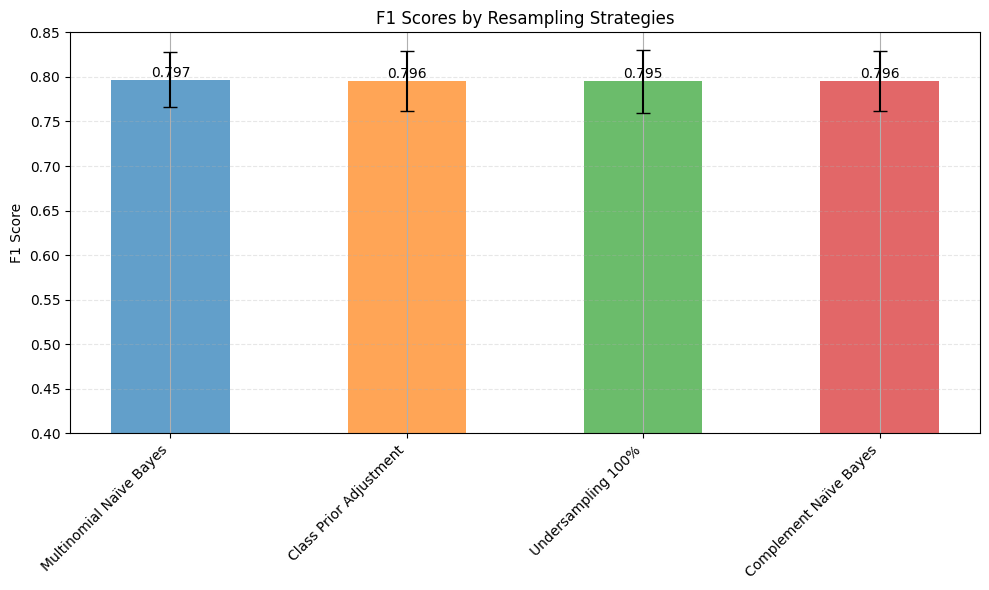

In [22]:
def plot_f1_scores(f1_scores):
    # Set basic style parameters
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True

    # Get dimensions
    pipelines = list(f1_scores.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate bar positions
    x = np.arange(len(pipelines))
    width = 0.5  # Can be wider now since we don't need to group bars

    # Define colors for better visibility
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot bars for each pipeline
    means = [f1_scores[pipeline][0] for pipeline in pipelines]
    stds = [f1_scores[pipeline][1] for pipeline in pipelines]
    
    bars = ax.bar(x, means, width, 
                  yerr=stds, 
                  capsize=5, 
                  color=colors[:len(pipelines)], 
                  alpha=0.7)

    # Customize the plot
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by Resampling Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels(pipelines, rotation=45, ha='right')

    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to focus on the relevant range
    ax.set_ylim(0.4, 0.85)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Create the plot
fig = plot_f1_scores(f1_scores)

# Show the plot
plt.show()

The `analyze_f1_scores` function is used to assesses the performance of the imbalance handling strategies on `X_train_combined`.

In [23]:
analyze_f1_scores(f1_scores)


Pipelines ranked by mean F1 score:
Pipeline: Multinomial Naïve Bayes
F1: 0.797 (±0.031)
Pipeline: Class Prior Adjustment
F1: 0.796 (±0.033)
Pipeline: Complement Naïve Bayes
F1: 0.796 (±0.033)

Pipelines ranked by stability (lowest std):
Pipeline: Multinomial Naïve Bayes
F1: 0.797 (±0.031)
Pipeline: Class Prior Adjustment
F1: 0.796 (±0.033)
Pipeline: Complement Naïve Bayes
F1: 0.796 (±0.033)

Pipelines ranked by combined performance (mean - std):
Pipeline: Multinomial Naïve Bayes
F1: 0.797 (±0.031)
Pipeline: Class Prior Adjustment
F1: 0.796 (±0.033)
Pipeline: Complement Naïve Bayes
F1: 0.796 (±0.033)


Multinomial Naive Bayes with no imbalance handling marginally leads the others across mean F1, stability, and combined performance. It is therefore selected as the pipeline structure for the final `alpha` hyperparameter tuning for Model C.

The final optimization step involves retuning the `alpha` (smoothing parameter) of the `MultinomialNB` classifier.  A `param_grid` with `alpha` values `[0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0]` is defined. `GridSearchCV` performs a 5-fold stratified cross-validation on `X_train_combined` and `y_train_combined`, optimizing for `f1_macro`, to identify the best `alpha` for Model C.

In [24]:
# Define parameter grid
param_grid = {
    'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0]
}

# Create grid search with your best pipeline
grid_search = GridSearchCV(
    mb_naive_bayes,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train_combined, y_train_combined)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-macro: {grid_search.best_score_}")

Best parameters: {'classifier__alpha': 0.5}
Best F1-macro: 0.798988834574091


This final Model C is trained on the complete `X_train_combined` and `y_train_combined` datasets. Its performance is then evaluated on the original `jerbarnes_dataset` test split (`X_test`, `y_test`) for a fair comparison against previous models. The classification report is printed, and the metrics are stored as `model_c_results`.

In [25]:
final_model = ImbPipeline([
    ('vectorizer', CountVectorizer(min_df=2, lowercase=False, strip_accents=None, stop_words=None, ngram_range=(1, 2))),
    ('classifier', MultinomialNB(alpha=0.5)),
])

# Train the model
final_model.fit(X_train_combined, y_train_combined)

# Make predictions and evaluate
y_pred = final_model.predict(X_test)

model_c_results = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       119
           1       0.72      0.50      0.59        52

    accuracy                           0.79       171
   macro avg       0.76      0.71      0.72       171
weighted avg       0.78      0.79      0.78       171



The `generate_multi_model_comparison_table` function is defined to consolidate metrics from multiple `classification_report` dictionaries into a single, formatted pandas DataFrame.

In [32]:
def generate_multi_model_comparison_table(report_dicts, report_names):
    # Generates a comparison table from multiple classification report dictionaries.

    if len(report_dicts) != len(report_names):
        raise ValueError("The number of report_dicts must match the number of report_names.")

    table_data = []
    
    # Define the order of rows and metrics
    row_order = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']
    metric_keys_for_classes_and_avgs = ['precision', 'recall', 'f1-score'] 

    # Check which labels are present in at least one report to avoid empty rows
    # More robustly, get all unique labels present across all reports for rows
    all_labels_present = set()
    for report_dict in report_dicts:
        all_labels_present.update(report_dict.keys())
    
    # Filter row_order to only include labels that are actually present
    # and maintain the desired order
    ordered_labels_to_display = [label for label in row_order if label in all_labels_present]


    for label in ordered_labels_to_display:
        if label == 'accuracy':
            row_entry = {'Class/Avg': 'Overall', 'Metric': 'Accuracy'}
            for i, report_dict in enumerate(report_dicts):
                row_entry[report_names[i]] = report_dict.get(label, 'N/A')
            table_data.append(row_entry)
        else: # For classes '0', '1', 'macro avg', 'weighted avg'
            for metric in metric_keys_for_classes_and_avgs:
                row_entry = {'Class/Avg': label, 'Metric': metric}
                for i, report_dict in enumerate(report_dicts):
                    # report_dict[label] is itself a dictionary like {'precision': ..., 'recall': ...}
                    row_entry[report_names[i]] = report_dict.get(label, {}).get(metric, 'N/A')
                table_data.append(row_entry)

    df_comparison = pd.DataFrame(table_data)
    
    # Define column order
    cols = ['Class/Avg', 'Metric'] + report_names
    df_comparison = df_comparison[cols]
    
    return df_comparison


all_report_dicts = [model_a_results, model_b_results, model_c_results]
all_report_names = [
    "Jerbarnes (ComplementalNB, alpha=0.75)", 
    "Combined Data (ComplementalNB, alpha=0.75)", 
    "Combined Data (Optimized: MultinomialNB, alpha=0.5))"
]

# Generate and print the comparison table.**
multi_comparison_df = generate_multi_model_comparison_table(all_report_dicts, all_report_names)

# Set pandas display options for better viewing
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) # Adjust width as needed or remove for auto
pd.set_option('display.float_format', '{:.2f}'.format) # Format floats to 2 decimal places

print("\nMulti-Model Comparison of Classification Reports:")
display(multi_comparison_df)



Multi-Model Comparison of Classification Reports:


,Class/Avg,Metric,"Jerbarnes (ComplementalNB, alpha=0.75)","Combined Data (ComplementalNB, alpha=0.75)","Combined Data (Optimized: MultinomialNB, alpha=0.5))"
0,0,precision,0.79,0.81,0.81
1,0,recall,0.82,0.91,0.92
2,0,f1-score,0.81,0.85,0.86
3,1,precision,0.55,0.70,0.72
4,1,recall,0.50,0.50,0.50
5,1,f1-score,0.53,0.58,0.59
6,Overall,Accuracy,0.73,0.78,0.79
7,macro avg,precision,0.67,0.75,0.76
8,macro avg,recall,0.66,0.70,0.71
9,macro avg,f1-score,0.67,0.72,0.72
